In [1]:
# import visual_genome.local as vg
from tqdm import tqdm
import matplotlib.pyplot as plt
 
# DATA_PATH = '/local/home/stuff/visual-genome/'
LOCAL_DATA_PATH = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/'

In [2]:
import json
# you need to download the scene graph data from visual genome, it's not included in dario's folder (and i don't have write access there)
with open(LOCAL_DATA_PATH+'raw/scene_graphs.json', 'r') as f:
    scene_graphs_dict = json.load(f)

In [3]:
import networkx as nx

def build_graph(g_dict):
        G = nx.DiGraph(image_id=g_dict['image_id'])
        G.labels = {}
        for obj in g_dict['objects']:
            G.add_node(obj['object_id'], w=obj['w'], h=obj['h'], x=obj['x'], y=obj['y'], attributes=obj.get('attributes',[]), name=obj['names'][0])
            G.labels[obj['object_id']] = obj['names'][0]
        for rel in g_dict['relationships']:
            G.add_edge(rel['subject_id'], rel['object_id'], synsets=rel['synsets'] ,relationship_id=rel['relationship_id'], predicate=rel['predicate'])
        return G
    

In [4]:
graphs = [] 
for g_dict in tqdm(scene_graphs_dict):
    graphs.append(build_graph(g_dict))

100%|██████████| 108077/108077 [00:22<00:00, 4810.10it/s]


In [5]:
# access of node attributes
print(graphs[0].nodes[1058525]['w'])
# access of edge attributes
print(graphs[0].edges[(5045,5046)]['predicate'])
# iterate over edges
print(list(graphs[0].edges)[0])

46
ON
(5045, 5046)


In [6]:
def plot_graph(g):
    pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
    max_y = max([y for x,y in pos.values()])
    n_nodes_top = len([n for n in g.nodes if pos[n][1] == max_y])
    longest_label = max([len(g.labels[n]) for n in g.nodes])
    plt.figure(figsize=(max(n_nodes_top*longest_label/10,15),5))
    nx.draw(g,pos=pos,labels=g.labels, with_labels=True, node_size=10, node_color="lightgray", font_size=8)
    nx.draw_networkx_edge_labels(g,pos=pos,edge_labels=nx.get_edge_attributes(g,'predicate'),font_size=8)
    plt.show()

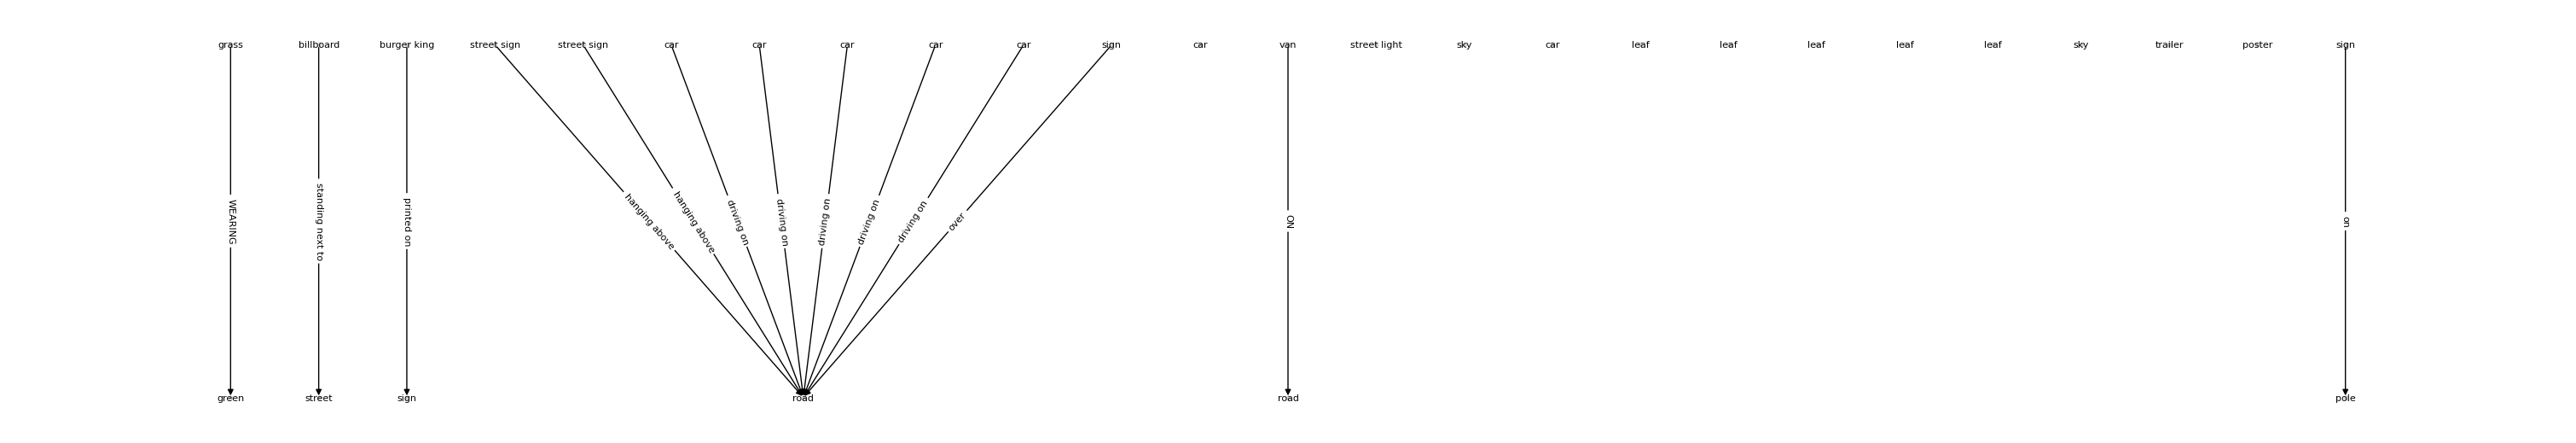

86690


In [7]:
import random
idx = random.randint(0,len(graphs))
plot_graph(graphs[idx])
print(idx)

# Building adversarial graphs
Here we focus on unrealistic adversarial graphs. I.e. graphs where we swap some relations with other arbitrary ones. For correct model evaluation, this is not enough, i.e. to know confidently, that a model can distinguis different relations itself (and not only check if a combination of objects and relation is itself unrealistic independently of the image) we will need a manually curated dataset.

In [17]:
import torch
relationship_labels = torch.load(LOCAL_DATA_PATH+'processed/filtered_relationship_labels.pt')
rel_set = set(relationship_labels)

def convert_adversarially(g):
    # convert to adversarial graph by looking for one edge that is in the relationship labels and replacing it with a random one from the relationship labels
    # we remove trailing spaces and convert to lower case
    indexes = [i for i, e in enumerate(g.edges) if g.edges[e]['predicate'].strip().lower() in rel_set]
    found_edge = False
    if len(indexes) > 0:
        idx = random.choice(indexes)
        e = list(g.edges)[idx]
        old_label = g.edges[e]['predicate']
        g.edges[e]['predicate'] = random.choice(relationship_labels)
        found_edge = True
        print('replaced edge', old_label, 'with', g.edges[e]['predicate'])
    return g, found_edge

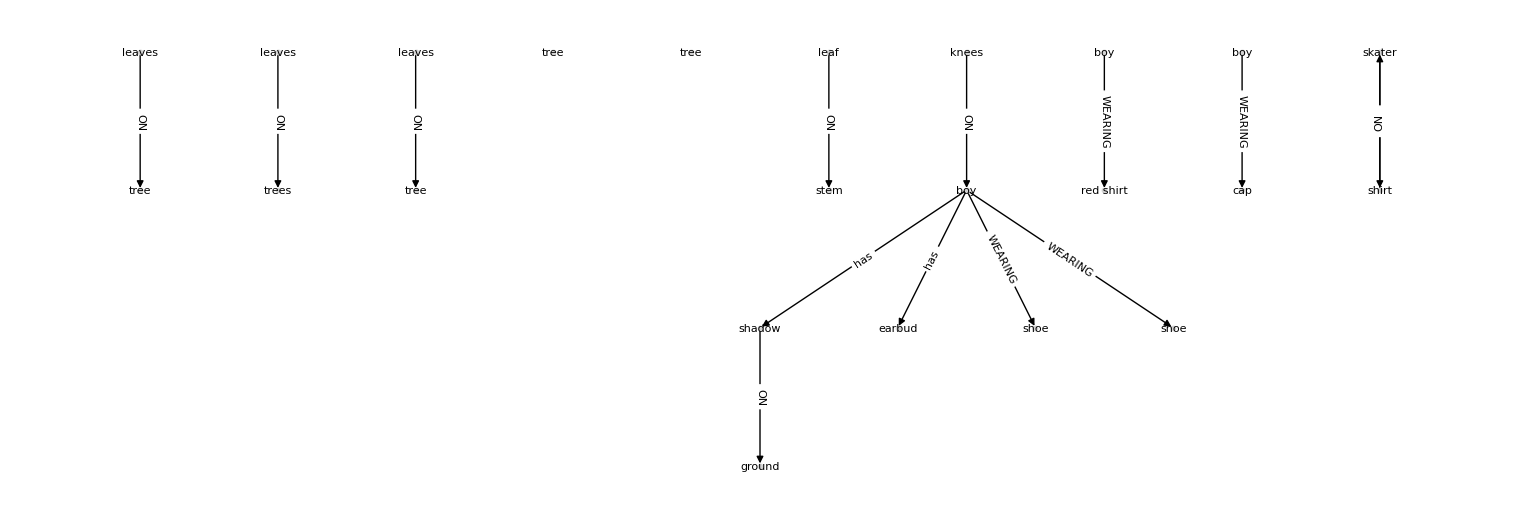

85354
replaced edge ON with mounted on


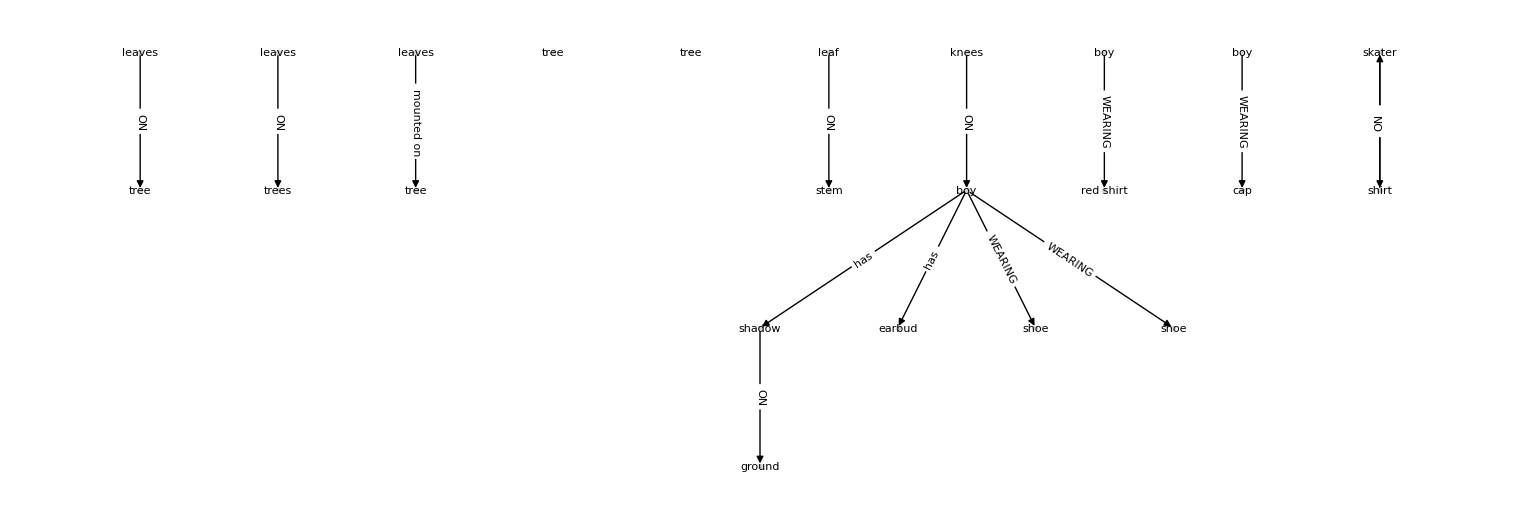

True


In [21]:
import random
idx = random.randint(0,len(graphs))
plot_graph(graphs[idx])
print(idx)
g_adv, found_edge = convert_adversarially(graphs[idx])
plot_graph(g_adv)
print(found_edge)